# Peter Duggins
# SYDE 552/750
# Assignment: Linear-Nonlinear Poisson Models
# March 22, 2016

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.optimize import curve_fit
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['font.size'] = 20

Populating the interactive namespace from numpy and matplotlib


## 1. Spike Statistics

Generate 50 10-second trials of Poisson spikes at 25 spikes/s witha 5ms absolute refractory period. To do this, draw samples from an approprpiate ISI distribution.

In [4]:
def generate_poisson_spikes(T,dt,trials,rate,rng):
    
	#I'll implement the 5ms refractory period as using dt=5ms.
	spike_raster=[]
	spike_times=[]
	for trial in range(trials):
		spike_raster_trial=[]
		spike_times_trial=[]
		for t in range(int(T/dt)):
			spike_here=(rng.rand()<rate*dt)
			spike_raster_trial.append(1*spike_here)
			if spike_here:
				spike_times_trial.append(t*dt)
		spike_raster.append(spike_raster_trial)
		spike_times.append(spike_times_trial)
	return np.array(spike_raster),np.array(spike_times)

def get_ISI(spike_times):

	#calculate across all trials
	ISI=[]
	for trial in range(len(spike_times)):
		for t in range(len(spike_times[trial])-1):
			ISI.append(spike_times[trial][t+1]-spike_times[trial][t])
	return ISI

def get_CV(ISI):

	return np.std(ISI)/np.average(ISI)

def get_fano_factor(spike_raster,t_range):

	count=[np.sum(raster[:t_range]) for raster in spike_raster]
	avg=np.average(count)
	if avg != 0:
		var=np.var(count)
	else:
		var=0
	return var/avg

def get_fano_factor_list(T,dt,trials,rate,rng,n_FFs,t_range):

	FF_list=[]
	for i in range(n_FFs):
		spike_raster, spike_times = generate_poisson_spikes(T,dt,trials,rate,rng)
		FF_i=get_fano_factor(spike_raster,t_range)
		FF_list.append(FF_i)
	return FF_list

Plot the spike raster (1s) and the ISI histogram (10ms bins from 0-500ms)

Calculate the coefficient of variation of the spike rate over all trials.

Calculate the Fano factor for the first 100ms. Comment on the consistency of the Fano factor over multiple runs. Comment on the difference in Fano factors with 5ms vs 1ms refractory period.

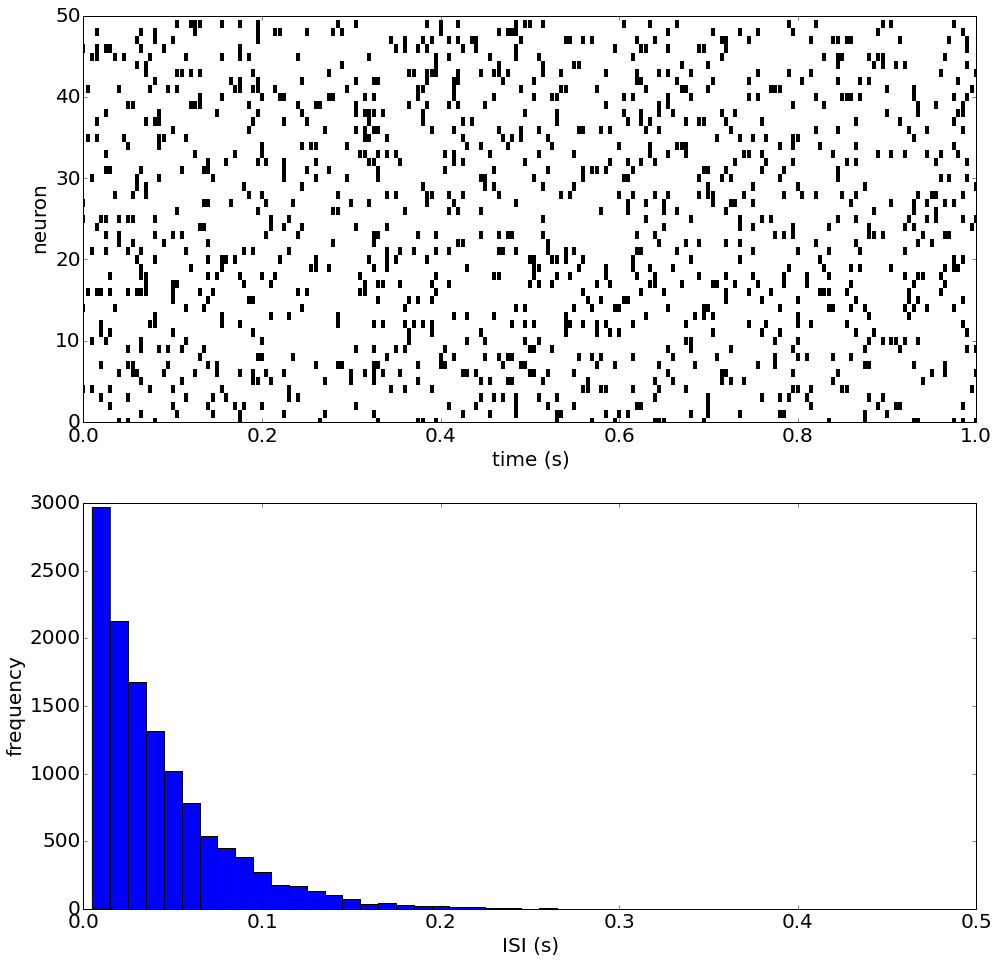

The coefficient of variation is 0.919684065222
Fano Factor for $t_{ref}=0.005$, 50 trials:
mean: 0.839471102108 std: 0.176345519687
Fano Factor for $t_{ref}=0.001$, 50 trials:
mean: 0.942815010008 std: 0.191469341661


In [6]:
def one():

	T=10 #seconds
	dt=0.005
	trials=50
	rate=25 #Hz
	seed=3
	t=np.arange(0,T,dt)
	rng=np.random.RandomState(seed=seed)

	spike_raster, spike_times = generate_poisson_spikes(T,dt,trials,rate,rng)

	ISI = get_ISI(spike_times)
	n_bins=int(np.max(ISI)/(2*dt))

	#Plot the spike raster for first 1.0 seconds
	fig=plt.figure(figsize=(16,16))
	ax=fig.add_subplot(211)
	ax.eventplot(spike_times,colors=[[0,0,0]])
	ax.set_xlim(0,1.0)
	ax.set_ylim(0,trials)
	ax.set_xlabel('time (s)')
	ax.set_ylabel('neuron')

	#plot ISI histogram
	ax=fig.add_subplot(212)
	ax.hist(ISI,n_bins)
	ax.set_xlim(0,dt*100)
	ax.set_xlabel('ISI (s)')
	ax.set_ylabel('frequency')
	plt.show()

	CV = get_CV(ISI)
	print "The coefficient of variation is", CV

	t_range=int(0.100/dt)
	n_FFs = 50

	FF_list_1 = get_fano_factor_list(T,dt,trials,rate,rng,n_FFs,t_range)
	print "Fano Factor for $t_{ref}=%s$, %s trials:" %(dt, n_FFs)
	print "mean: %s" %np.average(FF_list_1), "std: %s" %np.std(FF_list_1)

	dt=0.001
	FF_list_2 = get_fano_factor_list(T,dt,trials,rate,rng,n_FFs,t_range)
	print "Fano Factor for $t_{ref}=%s$, %s trials:" %(dt, n_FFs)
	print "mean: %s" %np.average(FF_list_2), "std: %s" %np.std(FF_list_2)
    
one()

The Fano factor is significantly below 1 with a 5ms refractory period (mean=0.83), but will sometimes reach the expected value of 1.0 due to its high standard deviation across trials (std=0.18).

A smaller refractory period of 1ms brings the Fano factor significantly closer to 1 (mean=0.94), but the standard deviation across trials remains as high (or higher) as with the long refractory period (std=0.19).

## 2. LNP Models

Create a linear poisson model of the synthetic neuron given in the previous assignment (Neuron Responses). To do this, convolve white noise (dt=0.001s, mean=0.0, std=1.0) with a kernel calculated using the spike-triggered average of that signal (use the STA method from the previous assignment). Plot 1s of the white noise stimulus alongside the firing rate prediction from the linear poisson model.

In [8]:
def white_noise(mean=0.0,std=1.0,T=100,dt=0.001,rng=np.random.RandomState()):
	return rng.normal(mean,std,T/dt)

def synthetic_neuron(drive,rng):
	"""
	Simulates a mock neuron with a time step of 1ms.
	Arguments:
	drive - input to the neuron (expect zero mean; SD=1)
	Returns:
	rho - response function (0=non-spike and 1=spike at each time step)
	"""	
	  
	dt = 0.001
	T = dt*len(drive)
	time = np.arange(0, T, dt)
	lagSteps = 0.02/dt
	drive = np.concatenate((np.zeros(lagSteps), drive[lagSteps:]))
	system = scipy.signal.lti([1], [0.03**2, 2*0.03, 1])
	_, L, _ = scipy.signal.lsim(system, drive[:,np.newaxis], time)
	rate = np.divide(30, 1 + np.exp(50*(0.05-L)))
	spikeProb = rate*dt
	return rng.rand(len(spikeProb)) < spikeProb

def spike_trig_avg(stim,spikes,dt,window_width):

	window = np.arange(0,int(window_width / dt),1)
	#truncate spikes in first window timesteps
	spike_indices=np.where(spikes[len(window):]==1)[0].flatten()
	spike_triggered_avg=[]
	for t in window:
		stim_sum_i=[]
		for i in spike_indices:
			#undo truncation when indexing from stimulus
			stim_sum_i.append(stim[(i+len(window))-t])
		spike_triggered_avg.append(np.average(stim_sum_i))

	spike_triggered_avg=np.array(spike_triggered_avg).flatten()/len(spike_indices)

	return -1.0*window*dt, spike_triggered_avg

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


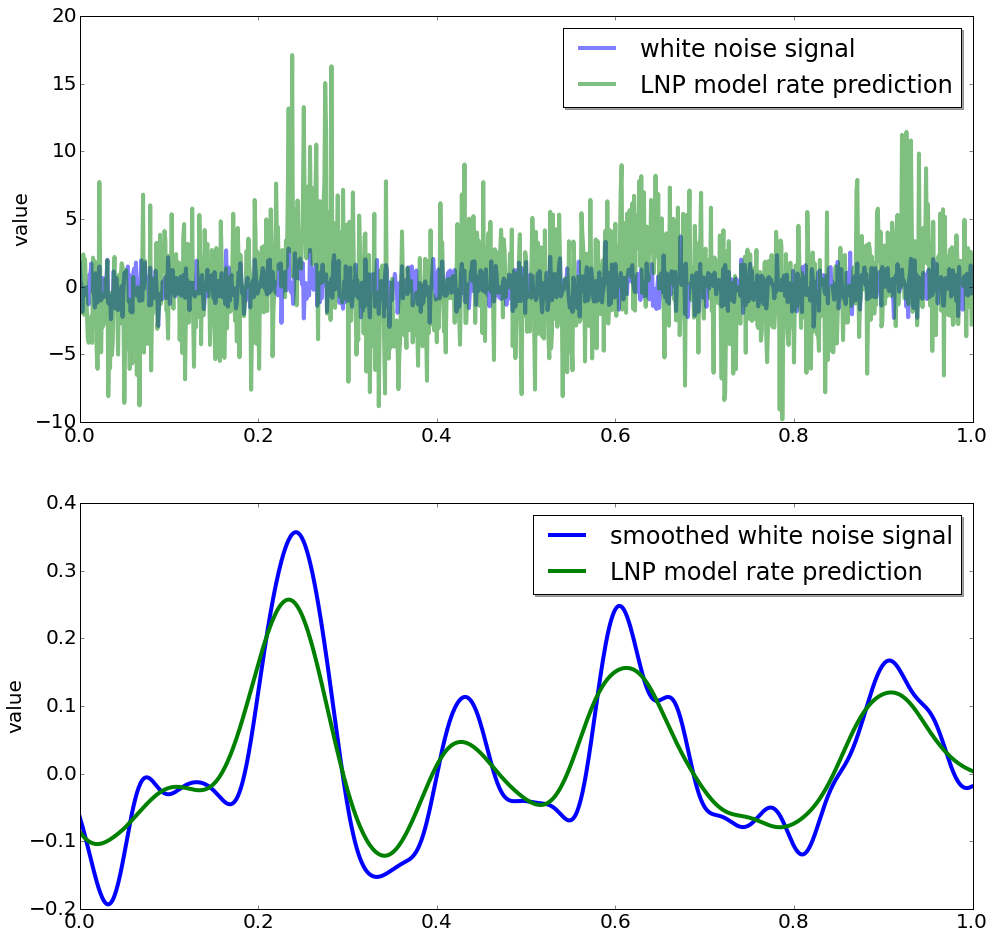

In [16]:
def two_a():

	T=1.0
	dt=0.001
	mean=0.0
	std=1.0
	seed=3

	#generate noisy signal with gaussian sampled numbers
	rng=np.random.RandomState(seed=seed)
	noise=white_noise(mean,std,T,dt,rng)
	t=np.arange(0,T,dt)

	#generate colored noise by convolving the noise signal with a gaussian
	sigma=0.020
	G = np.exp(-(t-np.average(t))**2/(2*sigma**2))     
	G = G / sum(G)
	colored_noise=np.convolve(noise,G,'same')

	#feed colored noise into Bryan's spike generator
	spikes=synthetic_neuron(noise,rng)
	smooth_spikes=synthetic_neuron(colored_noise,rng)
	rate=spikes.sum()/T
	smooth_rate=smooth_spikes.sum()/T

	#calculate the spike-triggered average
	window_width=0.100
	window, sta = spike_trig_avg(noise,spikes,dt,window_width)
	smooth_window, smooth_sta = spike_trig_avg(colored_noise,smooth_spikes,dt,window_width)

	#the math says to scale with <r> = rate, but this overshoots for smoothed noise
	kernel = rate * sta / std**2
	smooth_kernel = smooth_sta / std**2

	LNP = np.convolve(noise, kernel, mode='same')
	smooth_LNP = np.convolve(colored_noise, smooth_kernel, mode='same')

	#Plot the white noise signal together with the LNP rate prediction
	fig=plt.figure(figsize=(16,16))
	ax=fig.add_subplot(211)
	ax.plot(t,noise,label='white noise signal',alpha=0.5)
	ax.plot(t,LNP,label='LNP model rate prediction',alpha=0.5)
	# ax.set_xlim(0,T)
	legend=ax.legend(loc='best',shadow=True)
	# ax.set_xlabel('time (seconds)')
	ax.set_ylabel('value')
	ax=fig.add_subplot(212)
	ax.plot(t,colored_noise,label='smoothed white noise signal')
	ax.plot(t,smooth_LNP,label='LNP model rate prediction')
	# ax.set_xlim(0,T)
	legend=ax.legend(loc='best',shadow=True)
	# ax.set_xlabel('time (seconds)')
	ax.set_ylabel('value')
    
two_a()

Calculate and plot the multi-trial firing rate of the synthetic neuron (using methods from the previous assignment) over 250 repeated trials with the same white noise stimulus. Overlay the prediction from the linear poisson model.

Scatterplot the multi-trial firing rate vs. the linear poisson model prediction. Fit the neural nonlinearity using ```scipy.optimize.curve_fit()```.

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


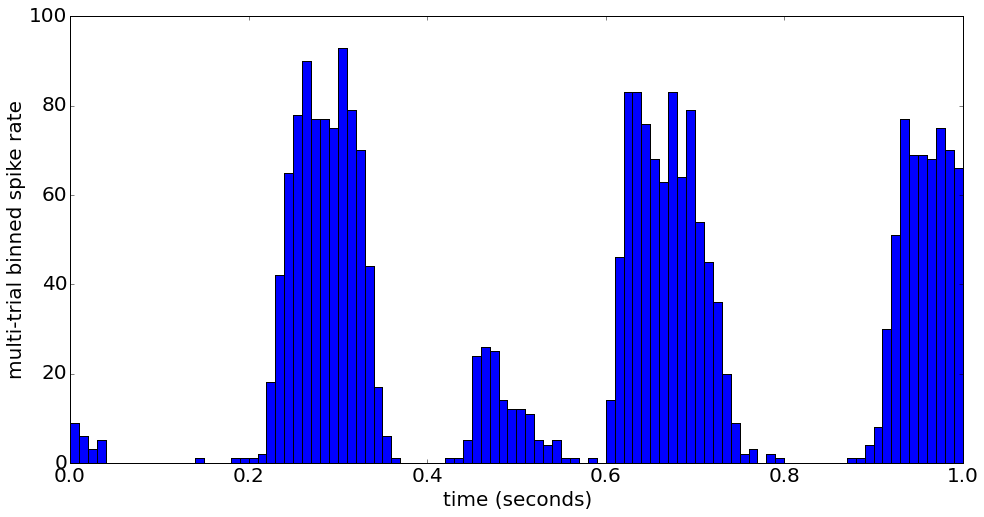

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:67: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:74: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


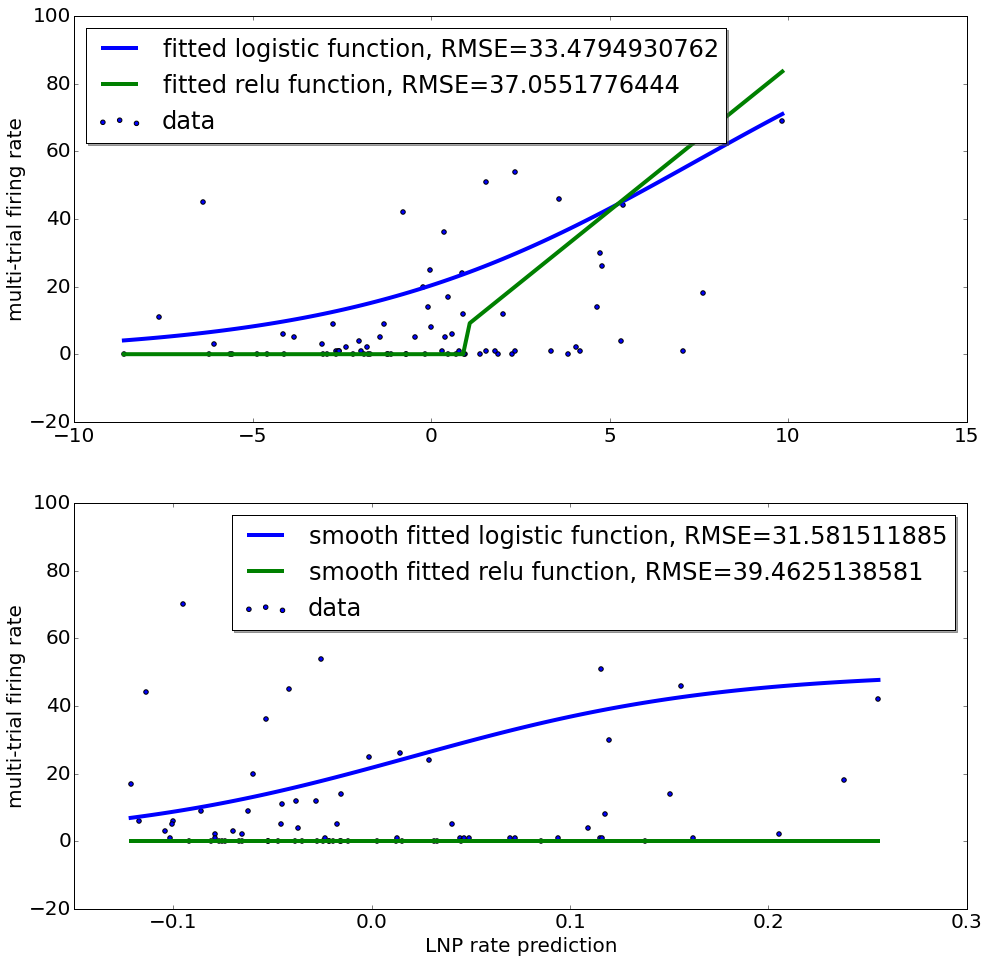

In [17]:
def two_b_thru_c():

	T=1.0
	dt=0.001
	mean=0.0
	std=1.0
	seed=3

	#generate noisy signal with gaussian sampled numbers
	rng=np.random.RandomState(seed=seed)
	noise=white_noise(mean,std,T,dt,rng)
	t=np.arange(0,T,dt)

	#generate colored noise by convolving the noise signal with a gaussian
	sigma=0.020
	G = np.exp(-(t-np.average(t))**2/(2*sigma**2))     
	G = G / sum(G)
	colored_noise=np.convolve(noise,G,'same')

	#feed colored noise into Bryan's spike generator
	spikes=synthetic_neuron(noise,rng)
	smooth_spikes=synthetic_neuron(colored_noise,rng)
	rate=spikes.sum()/T
	smooth_rate=smooth_spikes.sum()/T

	#calculate the spike-triggered average
	window_width=0.100
	window, sta = spike_trig_avg(noise,spikes,dt,window_width)
	smooth_window, smooth_sta = spike_trig_avg(colored_noise,smooth_spikes,dt,window_width)

	#the math says to scale with <r> = rate, but this overshoots for smoothed noise
	kernel = rate * sta / std**2
	smooth_kernel = smooth_sta / std**2

	LNP = np.convolve(noise, kernel, mode='same')
	smooth_LNP = np.convolve(colored_noise, smooth_kernel, mode='same')

	#Calculate the 'multi-trial' (or 'time-varying') firing rate
	#by counting the number of spikes in a small time window
	#accross all trials
	bin_width=0.010
	n_trials=250
	multitrial_binned_rate=[]
	for i in range(int(T/bin_width)):
		bin_i=0
		for j in range(n_trials):
			spikes=synthetic_neuron(noise,rng)
			spike_times=np.where(spikes==True)[0]*dt
			for t in spike_times:
				bin_i+=(i*bin_width<=t<(i+1)*bin_width)
		multitrial_binned_rate.append(bin_i)

	#plot the multitrial firing rate
	fig=plt.figure(figsize=(16,8))
	ax=fig.add_subplot(111)
	ax.bar(np.arange(0,T,bin_width),multitrial_binned_rate,width=bin_width)
	# ax.set_xlim(0,T)
	ax.set_xlabel('time (seconds)')
	ax.set_ylabel('multi-trial binned spike rate')
	plt.show()

	#curve fit the nonlinearity to a logistic (sigmoid) and rectified linear functions
	def logistic(t, a, b, c):
	    return a / (b + np.exp(c*t))
	def relu(t, threshold, m):
	    return m * t * (t > threshold)
	LNP_subset = LNP[::bin_width/dt]
	popt, pcov = curve_fit(logistic, LNP_subset, multitrial_binned_rate)
	popt2, pcov2 = curve_fit(relu, LNP_subset, multitrial_binned_rate)
	t_odd=np.linspace(np.min(LNP_subset),np.max(LNP_subset),100)
	fitted_logistic=logistic(t_odd,*popt)
	fitted_relu=relu(t_odd,*popt2)
	#curve fit to smoothed LNP prediction
	LNP_smooth_subset = smooth_LNP[::bin_width/dt]
	popt_smooth, pcov_smooth = curve_fit(logistic, LNP_smooth_subset, multitrial_binned_rate)
	popt2_smooth, pcov2_smooth = curve_fit(relu, LNP_smooth_subset, multitrial_binned_rate)
	t_odd_smooth=np.linspace(np.min(LNP_smooth_subset),np.max(LNP_smooth_subset),100)
	fitted_logistic_smooth=logistic(t_odd_smooth,*popt_smooth)
	fitted_relu_smooth=relu(t_odd_smooth,*popt2_smooth)

	#plot LNP rate prediction vs multitrial firing rate
	fig=plt.figure(figsize=(16,16))
	ax=fig.add_subplot(211)
	ax.scatter(LNP_subset,multitrial_binned_rate,label="data")
	ax.plot(t_odd,fitted_logistic,label='fitted logistic function, RMSE=%s'
				%np.sqrt(np.average((fitted_logistic-multitrial_binned_rate)**2)))
	ax.plot(t_odd,fitted_relu,label='fitted relu function, RMSE=%s'
				%np.sqrt(np.average((fitted_relu-multitrial_binned_rate)**2)))
	legend=ax.legend(loc='best',shadow=True)
	# ax.set_xlabel('LNP rate prediction')
	ax.set_ylabel('multi-trial firing rate')
	ax=fig.add_subplot(212)
	ax.scatter(LNP_smooth_subset,multitrial_binned_rate,label="data")
	ax.plot(t_odd_smooth,fitted_logistic_smooth,label='smooth fitted logistic function, RMSE=%s'
				%np.sqrt(np.average((fitted_logistic_smooth-multitrial_binned_rate)**2)))
	ax.plot(t_odd_smooth,fitted_relu_smooth,label='smooth fitted relu function, RMSE=%s'
				%np.sqrt(np.average((fitted_relu_smooth-multitrial_binned_rate)**2)))
	legend=ax.legend(loc='best',shadow=True)
	ax.set_xlabel('LNP rate prediction')
	ax.set_ylabel('multi-trial firing rate')
	plt.show()
    
two_b_thru_c()

Describe how you could generate spikes with a linear-nonlinear model of the synthetic neuron using the above results.

To estimate the firing rate of the synthetic neuron using an LNP model, I would generate a LP rate prediction as above (calculate the STA of the stimulus, use it to find the kernel, and convolve the stimulus with the kernel), then feed this estimate into a nonlinear activation function. This activation function could be optimized by using a curve fitting algorithm to find parameters which minimized the error between a trial dataset of firing rates and the LNP predictions, assuming a standard activation function such as a sigmoid, tanh, or rectified linear.